In [ ]:
from rdkit import Chem
import numpy as np
from rdkit.Chem import DataStructs, rdMolDescriptors, rdFingerprintGenerator, SDWriter
import random
from rdkit.Chem import Draw


# Liczymy podobieństwa inhibitorów

Zapisane w kolejności:
- **avibactam**: NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O
- **imipenem**: C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12
- **meropenem**: C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12


In [2]:
#inhibitory w smiles
inhibitor_smiles = [
    "NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O",
    "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12",
    "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12"
]

inhibitors = [Chem.MolFromSmiles(smiles) for smiles in inhibitor_smiles]

# Wczytaj fingerprinty inhibitorów przy użyciu MACCS
inhibitor_fps = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in inhibitors]

similarity_matrix = np.zeros((len(inhibitor_fps), len(inhibitor_fps)))

for i in range(len(inhibitor_fps)):
    for j in range(i, len(inhibitor_fps)):  
        similarity = DataStructs.TanimotoSimilarity(inhibitor_fps[i], inhibitor_fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity 

print("Macierz podobieństwa między inhibitorami:")
for i in range(len(inhibitor_smiles)):
    for j in range(len(inhibitor_smiles)):
        print(f"{similarity_matrix[i, j]:.3f}", end="\t")
    print()


Macierz podobieństwa między inhibitorami:
1.000	0.462	0.440	
0.462	1.000	0.768	
0.440	0.768	1.000	


Widzimy, że imipenem i meropenem są do sienie bardziej podobne (0.768), niż do avibactamu (około 0.4).

# Łączenie biblioteki potencjalnych związków
Kolejne pliki zawierają związki podobne do:
- CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[n+]3ccccc3)CS[C@H]12)c1csc(N)n1)C(=O)O
- CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N+]3(C)CCCC3)CS[C@H]12)c1csc(N)n1
- Nc1nc(/C(=N/O)C(=O)N[C@@H]2C(=O)N3C(C(=O)O)=C(/C=C4\CCN([C@@H]5CCNC5)C4=O)CS[C@H]23)ns1

W dwóch pierwszych po około 2000 związków, a w ostatnim 600.

Wynikowo dostajemy 2260 związków zapisanych w pliku 'polaczone_bialka_3D.sdf'.

In [3]:
# Generator fingerprintów Morgana z radius=3
gen = rdFingerprintGenerator.GetMorganGenerator(radius=3)

# Wczytaj pliki SDF 3D
sdf_files = ["compounds_3D\plik1.sdf", "compounds_3D\plik2.sdf", "compounds_3D\plik3.sdf"]
all_molecules = []
seen_fps = set()

# Wczytaj cząsteczki z plików SDF
for sdf_file in sdf_files:
    supplier = Chem.SDMolSupplier(sdf_file)
    for mol in supplier:
        if mol is not None:
            fp = gen.GetFingerprint(mol)  # Generowanie fingerprintu Morgana
            fp_bytes = fp.ToBinary()  # Konwersja fingerprintu do bajtów (porównywanie)

            # Sprawdzanie, czy fingerprint już występuje
            if fp_bytes not in seen_fps:
                seen_fps.add(fp_bytes)
                all_molecules.append(mol)

# Zapisywanie unikalnych cząsteczek do nowego pliku SDF
output_writer = SDWriter("polaczone_bialka_3D.sdf")
for mol in all_molecules:
    output_writer.write(mol)
output_writer.close()

print(f"Połączono i zapisano {len(all_molecules)} unikalnych cząsteczek do pliku 'polaczone_bialka_3D.sdf'")

Połączono i zapisano 2260 unikalnych cząsteczek do pliku 'polaczone_bialka_3D.sdf'


# Przykładowe związki

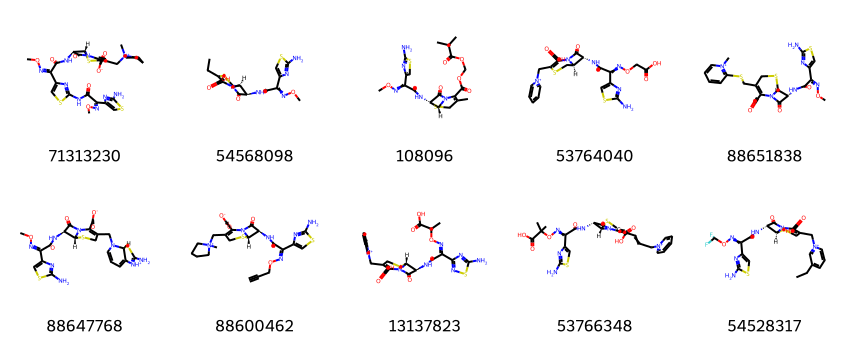

In [4]:
supplier = Chem.SDMolSupplier("polaczone_bialka_3D.sdf")
no_none=[mol for mol in supplier if mol]
[Chem.SanitizeMol(mol) for mol in no_none]
random_mols = random.sample(no_none, min(10, len(no_none)))
Draw.MolsToGridImage(random_mols, molsPerRow=5,subImgSize=(170,170),legends=[mol.GetProp('_Name') for mol in random_mols],maxMols=100)

# Sprawdzanie podobieństw związków
Z pliku 'polaczone_bialka_3D.sdf' sprawdzamy ich podobieństwa do naszych inhibitorów. Ma to nam ułatwić wybór struktury krystalicznej KPC-2.
Manipulując wyborem prawdopodobieństw tylko większych od danej wartości możemy sprawdzić ile jest związków bardzo podobnych. (np.where)

In [5]:
def calculate_similarity(sim_val, protein_sdf="polaczone_bialka_3D.sdf"):
    proteins = Chem.SDMolSupplier(protein_sdf)

    inhibitors = {
        "avibactam": "NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O",
        "imipenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12",
        "meropenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12"
    }

    inhibitor_mols = {name: Chem.MolFromSmiles(smiles) for name, smiles in inhibitors.items()}

    # Fingerprinty inhibitorów
    inhibitor_fps = {name: rdMolDescriptors.GetMACCSKeysFingerprint(mol) for name, mol in inhibitor_mols.items()}
    protein_fps = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in proteins if mol is not None]

    similarity_scores = []
    
    for name, inhibitor_fp in inhibitor_fps.items():
        similarities = np.array([DataStructs.TanimotoSimilarity(inhibitor_fp, protein_fp) for protein_fp in protein_fps])
        num_before = len(similarities)
        filtered_similarities = similarities[np.where(similarities > sim_val)]
        
        num_similarities = len(filtered_similarities)
        avg_similarity = np.mean(filtered_similarities) if num_similarities > 0 else 0
        
        similarity_scores.append((name, avg_similarity, num_similarities, num_before))

    # Sortowanie według średniego podobieństwa
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    for i, (name, avg_sim, num_sim, num_b) in enumerate(similarity_scores):
        if i == 1:
            print(f"Liczba związków przed filtracją: {num_b}")
        print(f"{i+1}. Inhibitor: {name}, Średnie podobieństwo: {avg_sim:.5f}, Liczba związków z podobieństwem > {sim_val}: {num_sim}")

    # Najlepszy inhibitor
    best_inhibitor = similarity_scores[0]
    print(f"\nNajlepiej dopasowany inhibitor: {best_inhibitor[0]} (Podobieństwo: {best_inhibitor[1]:.3f}, Liczba związków z podobieństwem > {sim_val}: {best_inhibitor[2]})")


In [6]:
calculate_similarity(0.58)

1. Inhibitor: avibactam, Średnie podobieństwo: 0.60556, Liczba związków z podobieństwem > 0.58: 46
Liczba związków przed filtracją: 2260
2. Inhibitor: imipenem, Średnie podobieństwo: 0.60449, Liczba związków z podobieństwem > 0.58: 775
3. Inhibitor: meropenem, Średnie podobieństwo: 0.59430, Liczba związków z podobieństwem > 0.58: 177

Najlepiej dopasowany inhibitor: avibactam (Podobieństwo: 0.606, Liczba związków z podobieństwem > 0.58: 46)


In [7]:
calculate_similarity(0.55)

1. Inhibitor: imipenem, Średnie podobieństwo: 0.58520, Liczba związków z podobieństwem > 0.55: 1487
Liczba związków przed filtracją: 2260
2. Inhibitor: avibactam, Średnie podobieństwo: 0.57056, Liczba związków z podobieństwem > 0.55: 256
3. Inhibitor: meropenem, Średnie podobieństwo: 0.56926, Liczba związków z podobieństwem > 0.55: 847

Najlepiej dopasowany inhibitor: imipenem (Podobieństwo: 0.585, Liczba związków z podobieństwem > 0.55: 1487)


In [8]:
calculate_similarity(0.5)

1. Inhibitor: imipenem, Średnie podobieństwo: 0.56801, Liczba związków z podobieństwem > 0.5: 2219
Liczba związków przed filtracją: 2260
2. Inhibitor: meropenem, Średnie podobieństwo: 0.54571, Liczba związków z podobieństwem > 0.5: 2077
3. Inhibitor: avibactam, Średnie podobieństwo: 0.53185, Liczba związków z podobieństwem > 0.5: 1244

Najlepiej dopasowany inhibitor: imipenem (Podobieństwo: 0.568, Liczba związków z podobieństwem > 0.5: 2219)


Dostosowując wartości zmiennej sim_val możemy manipulować ilością związków jakie zostają do liczenia średniej. Potencjalne dostosowanie rozmiaru biblioteki do dokowania.

# Zapis do pliku mol2
Dla wybranej wartości podobieństwa i wybranego inhibitora można zapisać plik zawierający wybrane związki.
Analiza wcześniejszej funckji pozwala zauważyć dla jakich wartości jaki rozmiar biblioteki otrzymamy i zdecydować się na wybór ostatecznego inhibitora i wielkości biblioteki.

Możliwość ustawienia dodania wodorów przed zapisem.

In [9]:
def save_similar_proteins(sim_val, inhibitor_name, output_file="filtered_proteins.mol2", add_H = False, protein_sdf="polaczone_bialka_3D.sdf"):
    # Wczytanie białek z pliku SDF
    proteins = Chem.SDMolSupplier(protein_sdf)
    
    # Zdefiniowanie inhibitorów i ich SMILES
    inhibitors = {
        "avibactam": "NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O",
        "imipenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12",
        "meropenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12"
    }

    # Sprawdzenie, czy wybrany inhibitor jest dostępny w słowniku
    if inhibitor_name not in inhibitors:
        raise ValueError(f"Inhibitor o nazwie '{inhibitor_name}' nie został znaleziony w słowniku.")
    
    # Pobranie SMILES dla wybranego inhibitora
    inhibitor_smiles = inhibitors[inhibitor_name]
    
    # Tworzenie molekuły inhibitora z SMILES
    inhibitor_mol = Chem.MolFromSmiles(inhibitor_smiles)
    
    # Tworzenie fingerprinta dla inhibitora
    inhibitor_fp = rdMolDescriptors.GetMACCSKeysFingerprint(inhibitor_mol)
    
    # Obliczanie fingerprintów dla białek
    protein_fps = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in proteins if mol is not None]

    # Obliczanie podobieństwa Tanimoto między inhibitorem a białkami
    similarities = np.array([DataStructs.TanimotoSimilarity(inhibitor_fp, protein_fp) for protein_fp in protein_fps])

    # Filtracja białek, których podobieństwo do inhibitora jest większe niż sim_val
    filtered_proteins = [protein for i, protein in enumerate(proteins) if similarities[i] > sim_val]

    # Zapisanie filtracji białek do pliku .mol2
    mol_writer = Chem.SDWriter(output_file)
    
    for protein in filtered_proteins:
        if protein is not None:
            if add_H:
                # Dodanie atomów wodoru do białka
                protein = Chem.AddHs(protein)
            mol_writer.write(protein)

    mol_writer.close()

    print(f"Zapisano {len(filtered_proteins)} białka do pliku: {output_file}")

In [10]:
save_similar_proteins(0.55, 'imipenem', "filtered_proteins.mol2")

Zapisano 1487 białka do pliku: filtered_proteins.mol2


In [11]:
save_similar_proteins(0.55, 'imipenem', "filtered_proteins_with_H.mol2", True)

Zapisano 1487 białka do pliku: filtered_proteins_with_H.mol2
